In [ ]:
# autoreload magic
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
import numpy as np
import scipy
from scipy import stats


from utils.analysis_utils import (
    load_qa,
    load_debate, 
    load_verdict,
    load_debate_and_verdict,
    load_debate_and_verdict_and_qa,
    sort_and_color_by_model_family
)

from views.view_runs import get_verdict_configs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Analyze QA accuracy

In [3]:
filters = {
    # MODEL OPTIONS
    # 'config_model_name': "x-ai/grok-4-fast",
    'config_model_name': "openai/gpt-4o-mini",
    # 'config_model_name': "qwen/qwen-2.5-7b-instruct",
    # 'config_model_name': "meta-llama/llama-3-8b-instruct",

    # DATASET OPTIONS
    'config_dataset_name': "Idavidrein/gpqa",
    'config_dataset_subset': "gpqa_diamond",
    'config_dataset_split': "train",

    # 'config_dataset_name': "TIGER-Lab/MMLU-Pro",
    # 'config_dataset_subset': None,
    # 'config_dataset_split': "test",

    # OTHER OPTIONS
    'config_random_seed': 42,
    'config_num_choices': 2,
}


In [4]:
df = load_qa(filters)

accuracy = df['is_correct'].mean()
correct_count = df['is_correct'].sum()
total_count = len(df)

print(f"Accuracy: {accuracy:.2%}")
print(f"Correct: {correct_count}/{total_count}")

Accuracy: 56.85%
Correct: 112/197


### Analyze verdict accuracy

In [5]:
run_id = 'hdudzt0'

df = load_verdict(run_id)

accuracy = df['is_correct_verdict'].mean()
correct_count = df['is_correct_verdict'].sum()
total_count = len(df)

print(f"Accuracy: {accuracy:.2%}")
print(f"Correct: {correct_count}/{total_count}")

Accuracy: 64.80%
Correct: 127/196


### Compared Verdict to QA accuracy

In [6]:
# verdict_run_id = 'uh2gayc'
verdict_run_id = 'k26y5y6'

merged_df = load_debate_and_verdict_and_qa(verdict_run_id)

judge_qa = merged_df["is_correct_judge_qa"].mean().round(2) 
debater_qa = merged_df["is_correct_debater_qa"].mean().round(2)
debate_verdict = merged_df["is_correct_verdict"].mean().round(2)

print()
print(f'Judge QA: {judge_qa} ({merged_df["is_correct_judge_qa"].sum()}/{merged_df["is_correct_judge_qa"].count()})')
print(f'Debater QA: {debater_qa} ({merged_df["is_correct_debater_qa"].sum()}/{merged_df["is_correct_debater_qa"].count()})')
print(f'Debate Verdict: {debate_verdict} ({merged_df["is_correct_verdict"].sum()}/{merged_df["is_correct_verdict"].count()})')

starting records: 193
dropped 1 without judge QA
dropped 2 without debater QA
final records: 190

Judge QA: 0.57 (108/190)
Debater QA: 0.92 (175/190)
Debate Verdict: 0.74 (141/190)


In [7]:
# Display columns that start with 'config'
pd.set_option('display.max_columns', None)
config_columns = [col for col in merged_df.columns if col.startswith('config')]
merged_df[config_columns].head()

,config,config_debate_dataset_name,config_debate_dataset_subset,config_debate_dataset_split,config_debate_debater_model,config_debate_debater_temperature,config_debate_max_output_tokens,config_debate_debater_reasoning_effort,config_debate_debater_reasoning_max_tokens,config_debate_num_questions,config_debate_random_seed,config_debate_num_choices,config_debate_num_turns,config_debate_private_scratchpad,config_debate_public_argument_word_limit,config_debate_private_reasoning_word_limit,config_debate_max_threads,config_verdict_debate_run_id,config_verdict_judge_model,config_verdict_judge_temperature,config_verdict_max_output_tokens,config_verdict_judge_reasoning_effort,config_verdict_judge_reasoning_max_tokens,config_model_name_x,config_model_name_y
0,"{'dataset_name': 'Idavidrein/gpqa', 'dataset_s...",Idavidrein/gpqa,gpqa_diamond,train,x-ai/grok-4-fast,0.0,None,None,None,198,42,2,1,False,200,NaN,5000,17zguxe,openai/gpt-4o-mini,0.0,5000,None,None,openai/gpt-4o-mini,x-ai/grok-4-fast
1,"{'dataset_name': 'Idavidrein/gpqa', 'dataset_s...",Idavidrein/gpqa,gpqa_diamond,train,x-ai/grok-4-fast,0.0,None,None,None,198,42,2,1,False,200,NaN,5000,17zguxe,openai/gpt-4o-mini,0.0,5000,None,None,openai/gpt-4o-mini,x-ai/grok-4-fast
2,"{'dataset_name': 'Idavidrein/gpqa', 'dataset_s...",Idavidrein/gpqa,gpqa_diamond,train,x-ai/grok-4-fast,0.0,None,None,None,198,42,2,1,False,200,NaN,5000,17zguxe,openai/gpt-4o-mini,0.0,5000,None,None,openai/gpt-4o-mini,x-ai/grok-4-fast
3,"{'dataset_name': 'Idavidrein/gpqa', 'dataset_s...",Idavidrein/gpqa,gpqa_diamond,train,x-ai/grok-4-fast,0.0,None,None,None,198,42,2,1,False,200,NaN,5000,17zguxe,openai/gpt-4o-mini,0.0,5000,None,None,openai/gpt-4o-mini,x-ai/grok-4-fast
4,"{'dataset_name': 'Idavidrein/gpqa', 'dataset_s...",Idavidrein/gpqa,gpqa_diamond,train,x-ai/grok-4-fast,0.0,None,None,None,198,42,2,1,False,200,NaN,5000,17zguxe,openai/gpt-4o-mini,0.0,5000,None,None,openai/gpt-4o-mini,x-ai/grok-4-fast


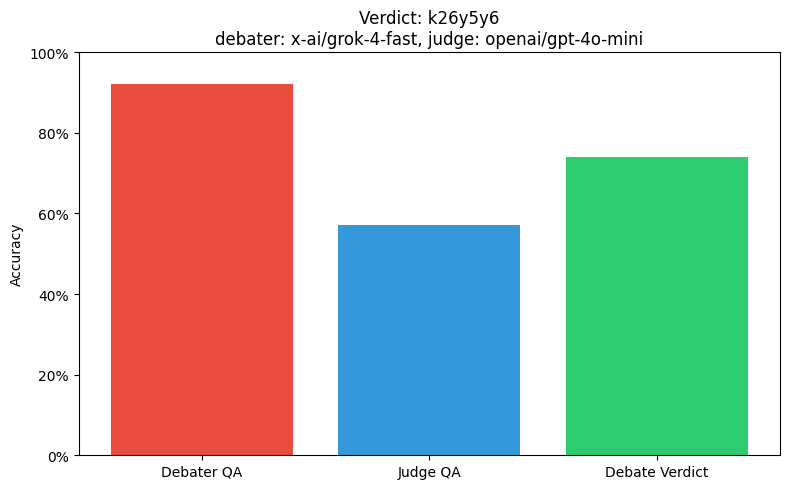

In [8]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(['Debater QA', 'Judge QA', 'Debate Verdict'], [debater_qa, judge_qa, debate_verdict], color=['#e74c3c', '#3498db', '#2ecc71'])                                                                                   
ax.set_ylabel('Accuracy')
ax.set_ylim(0, 1)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
debater_model = merged_df['config_debate_debater_model'].iloc[0]
judge_model = merged_df['config_verdict_judge_model'].iloc[0]
plt.title(f'Verdict: {verdict_run_id}\ndebater: {debater_model}, judge: {judge_model}')
plt.tight_layout()
plt.show()

### Compare accuracies across verdicts (by default, combine runs that have the same config)

In [314]:
from utils.analysis_utils import load_debate_and_verdict_and_qa, load_unique_over_runs

def results_by_config(unique_df, dedupe_columns):
    """
    Collapses across runs to get the unique records pertaining to each config (or, the config params that matter)
    """
    results = []
    # Get the unique records over runs
    dedupe_columns = [col for col in dedupe_columns if col != 'record_id']

    # Get the unique configs
    unique_configs = unique_df[dedupe_columns].drop_duplicates().to_dict('records')
    varying_cols = [col for col in dedupe_columns if unique_df[col].nunique() > 1]

    # Optionally, only keep records that are present for every verdict run
    # n_runs = len(unique_configs)
    # unique_df = unique_df.groupby('record_id').filter(lambda x: len(x) == n_runs)

    # Get the records and summary for each unique config
    for unique_config in unique_configs:
        filtered_df = unique_df.copy()
        for key, value in unique_config.items():
            if value is None or pd.isna(value):
                filtered_df = filtered_df[filtered_df[key].isna()]
            else:
                filtered_df = filtered_df[filtered_df[key] == value]

        # Name the column for the value of the varying columns
        name = ""
        for col in varying_cols:
            if col in unique_config:
                name += (f"{unique_config[col]},")
        name = name.strip(",")

        results.append({
            'name': name,
            'debater_qa_acc': filtered_df['is_correct_debater_qa'].mean(),
            'judge_qa_acc': filtered_df['is_correct_judge_qa'].mean(),
            'verdict_acc': filtered_df['is_correct_verdict'].mean(),
            'debater_qa_n_correct': filtered_df['is_correct_debater_qa'].sum(),
            'judge_qa_n_correct': filtered_df['is_correct_judge_qa'].sum(),
            'verdict_n_correct': filtered_df['is_correct_verdict'].sum(),
            'n_total': len(filtered_df),
            'verdict_minus_judge_qa': filtered_df['is_correct_verdict'].mean() - filtered_df['is_correct_judge_qa'].mean(),
            'pgr': (filtered_df['is_correct_verdict'].mean() - filtered_df['is_correct_judge_qa'].mean()) / (filtered_df['is_correct_debater_qa'].mean() - filtered_df['is_correct_judge_qa'].mean()),
        })

    results_df = pd.DataFrame(results)
    return results_df

def results_by_run(verdict_ids):
    results = []
    for vid in verdict_ids:
        df = load_debate_and_verdict_and_qa(vid)
        n = len(df)
        results.append({
            'name': vid,
            'debater_qa_acc': df['is_correct_debater_qa'].mean(),
            'judge_qa_acc': df['is_correct_judge_qa'].mean(),
            'verdict_acc': df['is_correct_verdict'].mean(),
            'debater_qa_n_correct': df['is_correct_debater_qa'].sum(),
            'judge_qa_n_correct': df['is_correct_judge_qa'].sum(),
            'verdict_n_correct': df['is_correct_verdict'].sum(),
            'n_total': n
        })
    results_df = pd.DataFrame(results)
    return results_df


In [ ]:
# verdict_ids = ['k26y5y6', 'kn8lecm', 'hmsolpd', 'okcg9s1']
# verdict_ids = ['yt32eoi', 'ouuwuug', 'qiqr2wo', '0va6ifr']
# results_df = results_by_run(verdict_ids)

# look at gqpa 4 choice and 2 choice (unique over runs)
verdicts_df = get_verdict_configs()

verdict_ids_gpqa_4_choice = verdicts_df[verdicts_df['debate_id'] == 'q6wpwb7']['verdict_id'].tolist()
unique_df_gpqa_4_choice, dedupe_columns_gpqa_4_choice = load_unique_over_runs(verdict_ids_gpqa_4_choice, 'load_debate_and_verdict_and_qa')
results_df_gpqa_4_choice = results_by_config(unique_df_gpqa_4_choice, dedupe_columns_gpqa_4_choice)

verdict_ids_gpqa_2_choice = verdicts_df[verdicts_df['debate_id'] == '17zguxe']['verdict_id'].tolist()
unique_df_gpqa_2_choice, dedupe_columns_gpqa_2_choice = load_unique_over_runs(verdict_ids_gpqa_2_choice, 'load_debate_and_verdict_and_qa')
results_df_gpqa_2_choice = results_by_config(unique_df_gpqa_2_choice, dedupe_columns_gpqa_2_choice)


loaded verdict: k26y5y6: starting records: 193, dropped 1 without judge QA, dropped 0 without debater QA, final records: 192
loaded verdict: kn8lecm: starting records: 190, dropped 1 without judge QA, dropped 0 without debater QA, final records: 189
loaded verdict: hqv1u8c: starting records: 159, dropped 6 without judge QA, dropped 0 without debater QA, final records: 153
loaded verdict: okcg9s1: starting records: 183, dropped 10 without judge QA, dropped 0 without debater QA, final records: 173
loaded verdict: clqsay7: starting records: 160, dropped 6 without judge QA, dropped 0 without debater QA, final records: 154
loaded verdict: hmsolpd: starting records: 189, dropped 6 without judge QA, dropped 0 without debater QA, final records: 183
loaded verdict: 2se1nyp: starting records: 170, dropped 10 without judge QA, dropped 0 without debater QA, final records: 160
loaded verdict: omurjjz: starting records: 181, dropped 32 without judge QA, dropped 0 without debater QA, final records: 1

debater_qa_acc: 0.84, judge_qa_acc: 0.45, verdict_acc: 0.54


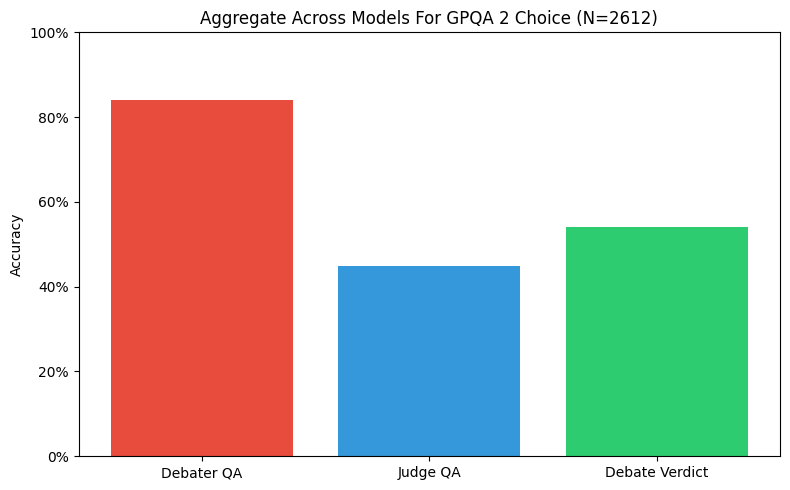

In [288]:
# results_df = results_df_gpqa_2_choice
results_df = results_df_gpqa_4_choice

total_records = results_df[f'n_total'].sum()
debater_qa = round(results_df[f'debater_qa_n_correct'].sum() /total_records, 2)
judge_qa = round(results_df[f'judge_qa_n_correct'].sum() /total_records, 2)
debate_verdict = round(results_df[f'verdict_n_correct'].sum() /total_records, 2)

print(f'debater_qa_acc: {debater_qa}, judge_qa_acc: {judge_qa}, verdict_acc: {debate_verdict}')

# Bar 
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(['Debater QA', 'Judge QA', 'Debate Verdict'], [debater_qa, judge_qa, debate_verdict], color=['#e74c3c', '#3498db', '#2ecc71'])                                                                                   
ax.set_ylabel('Accuracy')
ax.set_ylim(0, 1)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))

plt.title(f'Aggregate Across Models For GPQA {n_choices} Choice (N={total_records})')
plt.tight_layout()
plt.show()

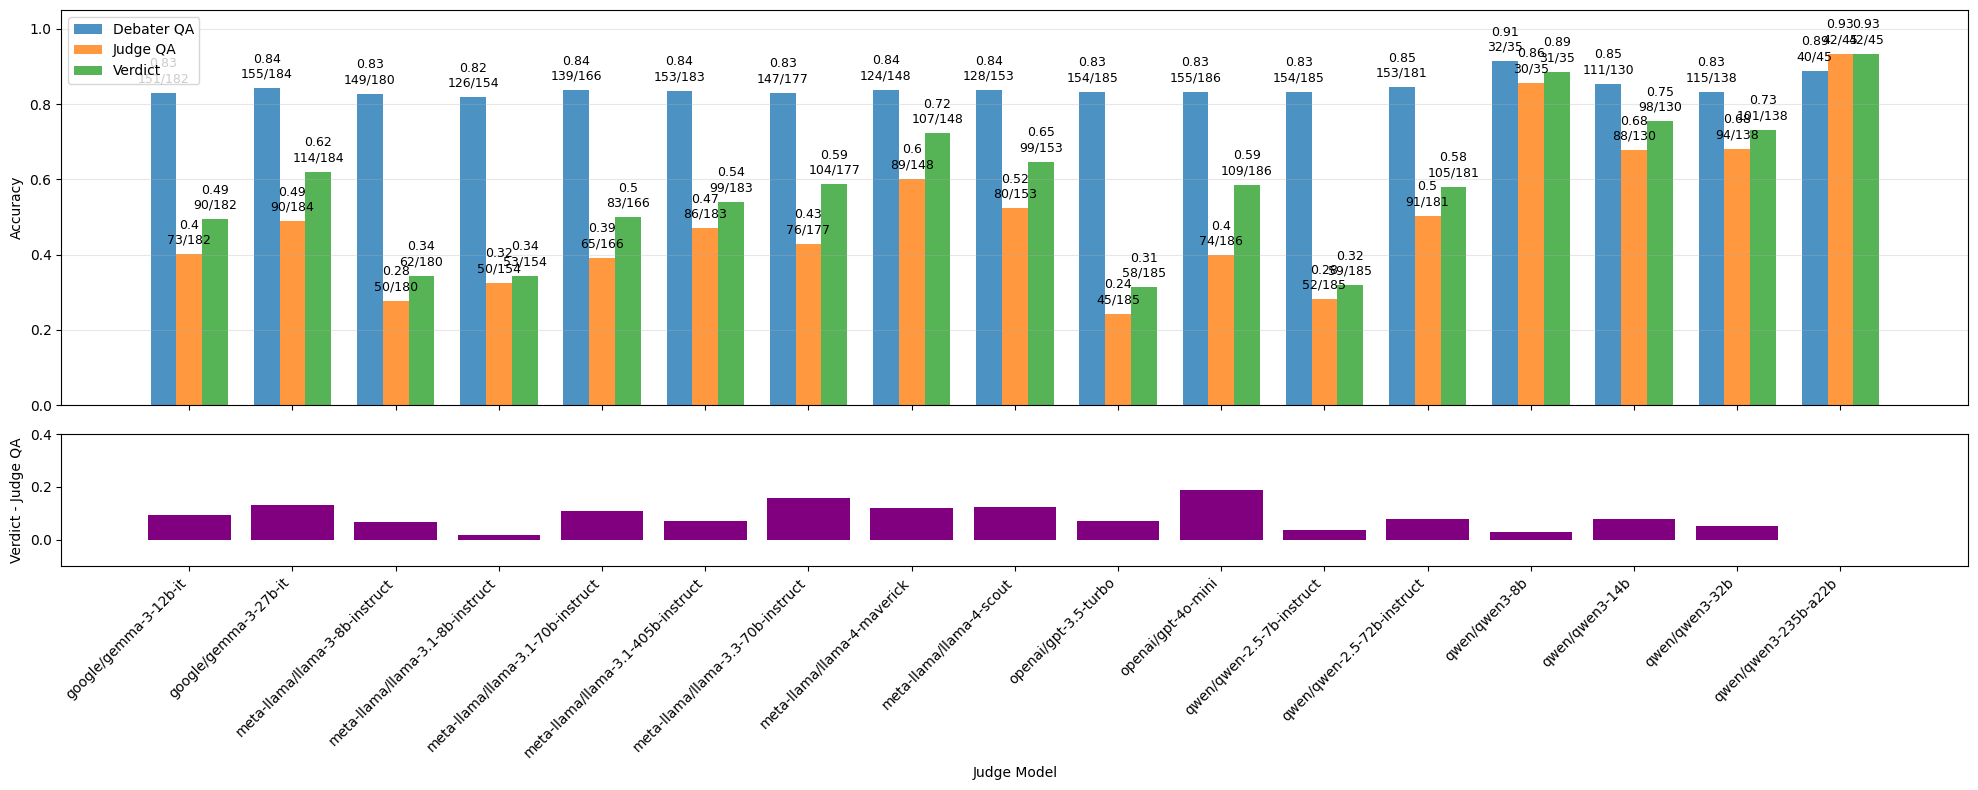

In [332]:
def plot_results_by_name(results_df):
        results_df['debater_minus_judge_qa'] = results_df['debater_qa_acc'] - results_df['judge_qa_acc']
        results_df['verdict_minus_judge_qa'] = results_df['verdict_acc'] - results_df['judge_qa_acc']


        names, _ = sort_and_color_by_model_family(results_df['name'].unique())
        results_df = results_df.set_index('name').loc[names].reset_index()

        fig, ax = plt.subplots(2, 1, figsize=(20, 8), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
        x = np.arange(len(results_df))
        width = 0.25

        bars1 = ax[0].bar(x - width, results_df['debater_qa_acc'], width, label='Debater QA', alpha=0.8)
        bars2 = ax[0].bar(x, results_df['judge_qa_acc'], width, label='Judge QA', alpha=0.8)
        bars3 = ax[0].bar(x + width, results_df['verdict_acc'], width, label='Verdict', alpha=0.8)

        for i, (b1, b2, b3) in enumerate(zip(bars1, bars2, bars3)):
                ratio1 = round(results_df.iloc[i]['debater_qa_acc'], 2)
                ratio2 = round(results_df.iloc[i]['judge_qa_acc'], 2)
                ratio3 = round(results_df.iloc[i]['verdict_acc'], 2)
        
                ax[0].text(b1.get_x() + b1.get_width()/2, b1.get_height() + 0.02, 
                        f"{ratio1}\n{results_df.iloc[i]['debater_qa_n_correct']:.0f}/{results_df.iloc[i]['n_total']}", 
                        ha='center', va='bottom', fontsize=9)
                ax[0].text(b2.get_x() + b2.get_width()/2, b2.get_height() + 0.02, 
                        f"{ratio2}\n{results_df.iloc[i]['judge_qa_n_correct']:.0f}/{results_df.iloc[i]['n_total']}", 
                        ha='center', va='bottom', fontsize=9)
                ax[0].text(b3.get_x() + b3.get_width()/2, b3.get_height() + 0.02, 
                        f"{ratio3}\n{results_df.iloc[i]['verdict_n_correct']:.0f}/{results_df.iloc[i]['n_total']}", 
                        ha='center', va='bottom', fontsize=9)

        ax[0].set_ylabel('Accuracy')
        ax[0].set_ylim(0, 1.05)
        ax[0].legend()
        ax[0].grid(axis='y', alpha=0.3)

        ax[1].set_xticks(x)
        ax[1].set_xticklabels(results_df['name'], rotation=45, ha='right')
        ax[1].set_xlabel('Judge Model')
        ax[1].bar(results_df['name'], results_df['verdict_minus_judge_qa'], color='purple')
        ax[1].set_ylim(-.1, 0.4)
        ax[1].set_ylabel('Verdict - Judge QA')

        # results_df['pgr'] = results_df['verdict_minus_judge_qa'] / results_df['debater_minus_judge_qa']
        # ax[1].bar(results_df['name'], results_df['pgr'], color='purple')
        # ax[1].set_ylim(-0.5, 0.8)
        # ax[1].set_ylabel('PGR')

        plt.tight_layout()
        plt.show()

# results_df = results_df_gpqa_2_choice
results_df = results_df_gpqa_4_choice

plot_results_by_name(results_df)

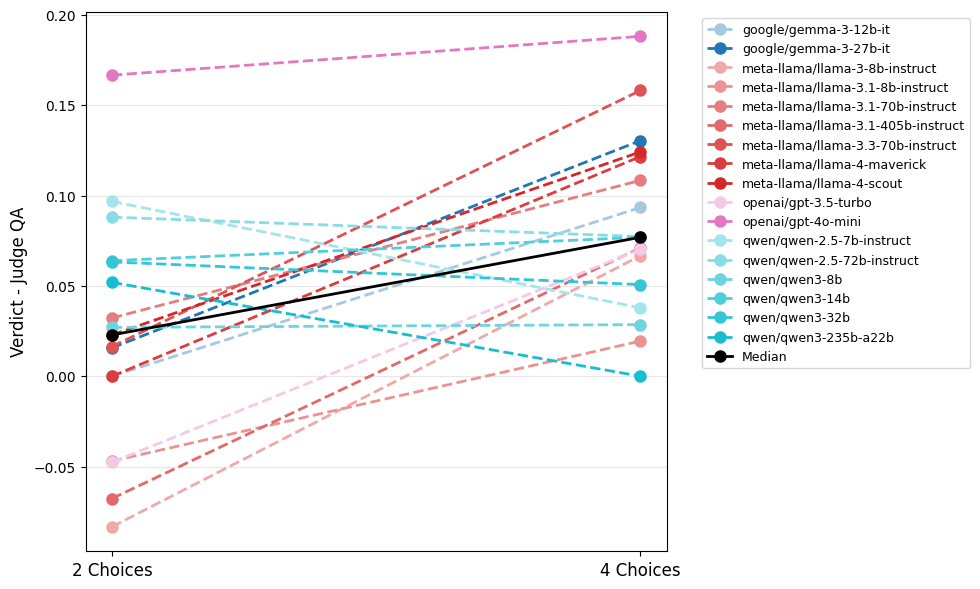

In [ ]:
merged = results_df_gpqa_2_choice.merge(
    results_df_gpqa_4_choice, 
    on='name', 
    suffixes=('_2choice', '_4choice')
)

sorted_names, color_map = sort_and_color_by_model_family(merged['name'].unique())
merged['sort_order'] = merged['name'].map({name: i for i, name in enumerate(sorted_names)})
merged = merged.sort_values('sort_order').reset_index(drop=True)

fig, ax = plt.subplots(figsize=(10, 6))

for _, row in merged.iterrows():
    ax.plot([0, 1], [row['verdict_minus_judge_qa_2choice'], row['verdict_minus_judge_qa_4choice']], 
            marker='o', label=row['name'], color=color_map[row['name']], linewidth=2, markersize=8, linestyle='--')

ax.plot([0, 1], [merged['verdict_minus_judge_qa_2choice'].median(), merged['verdict_minus_judge_qa_4choice'].median()], 
        marker='o', label='Median', color='black', linewidth=2, markersize=8, linestyle='-')

ax.set_xticks([0, 1])
ax.set_xticklabels(['2 Choices', '4 Choices'], fontsize=12)
ax.set_ylabel('Verdict - Judge QA', fontsize=12)
ax.grid(axis='y', alpha=0.3)

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.tight_layout()
plt.show()

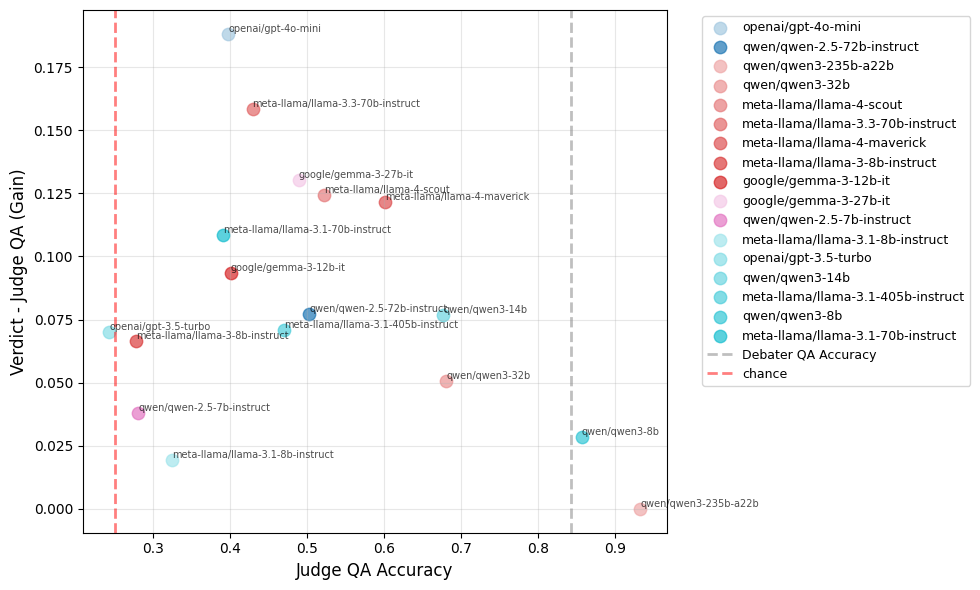

In [ ]:
# Plot the verdict_minus_judge_qa as a function of the difference in debater_qa and judge_qa

def plot_gain_scatter(results_df, n_choices, over: Literal["gap", "judge_qa"] = 'gap'):

    fig, ax = plt.subplots(figsize=(10, 6))

    results_df[f'debater_minus_judge'] = results_df[f'debater_qa_acc'] - results_df[f'judge_qa_acc']

    if over == 'gap':
        xfield = f'debater_minus_judge'
    elif over == 'judge_qa':
        xfield = f'judge_qa_acc'

    x = results_df[xfield]
    y = results_df[f'verdict_minus_judge_qa']

    for i, row in results_df.iterrows():
        x_val = row[xfield]
        y_val = row[f'verdict_minus_judge_qa']
        
        ax.scatter(x_val, y_val, color=colors[i], alpha=0.7, s=80, label=row['name'])
        ax.annotate(row['name'], (x_val, y_val), fontsize=7, ha='left', va='bottom', alpha=0.7)

    if xfield == f'judge_qa_acc':
        # Add the f'debater_qa_acc' as a vertical line
        ax.axvline(x=results_df[f'debater_qa_acc'].mean(), color='gray', linestyle='--', linewidth=2, alpha=0.5, label=f'Debater QA Accuracy')
        # Add the change line as a vertical line - it's 1/N_choices
        ax.axvline(x=1/n_choices, color='red', linestyle='--', linewidth=2, alpha=0.5, label='chance')

    # linear fit
    # slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    # r_squared = r_value**2
    # x_line = np.linspace(x.min(), x.max(), 100)
    # y_line = slope * x_line + intercept
    # ax.plot(x_line, y_line, 'k--', linewidth=2, alpha=0.5, label=f'Linear fit')
    # stats_text = f'R² = {r_squared:.3f}\np = {p_value:.4f}\nslope = {slope:.3f}'
    # ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=11,
            # verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    field_to_axis_label_map = {
        f'debater_minus_judge': 'Debater QA - Judge QA (Gap)',
        f'judge_qa_acc': 'Judge QA Accuracy'
    }

    ax.set_xlabel(field_to_axis_label_map[xfield], fontsize=12)
    ax.set_ylabel('Verdict - Judge QA (Gain)', fontsize=12)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    ax.grid(axis='both', alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_gain_scatter(results_df_gpqa_4_choice, n_choices=4)
# plot_gain_scatter(results_df_gpqa_2_choice, n_choices=2)



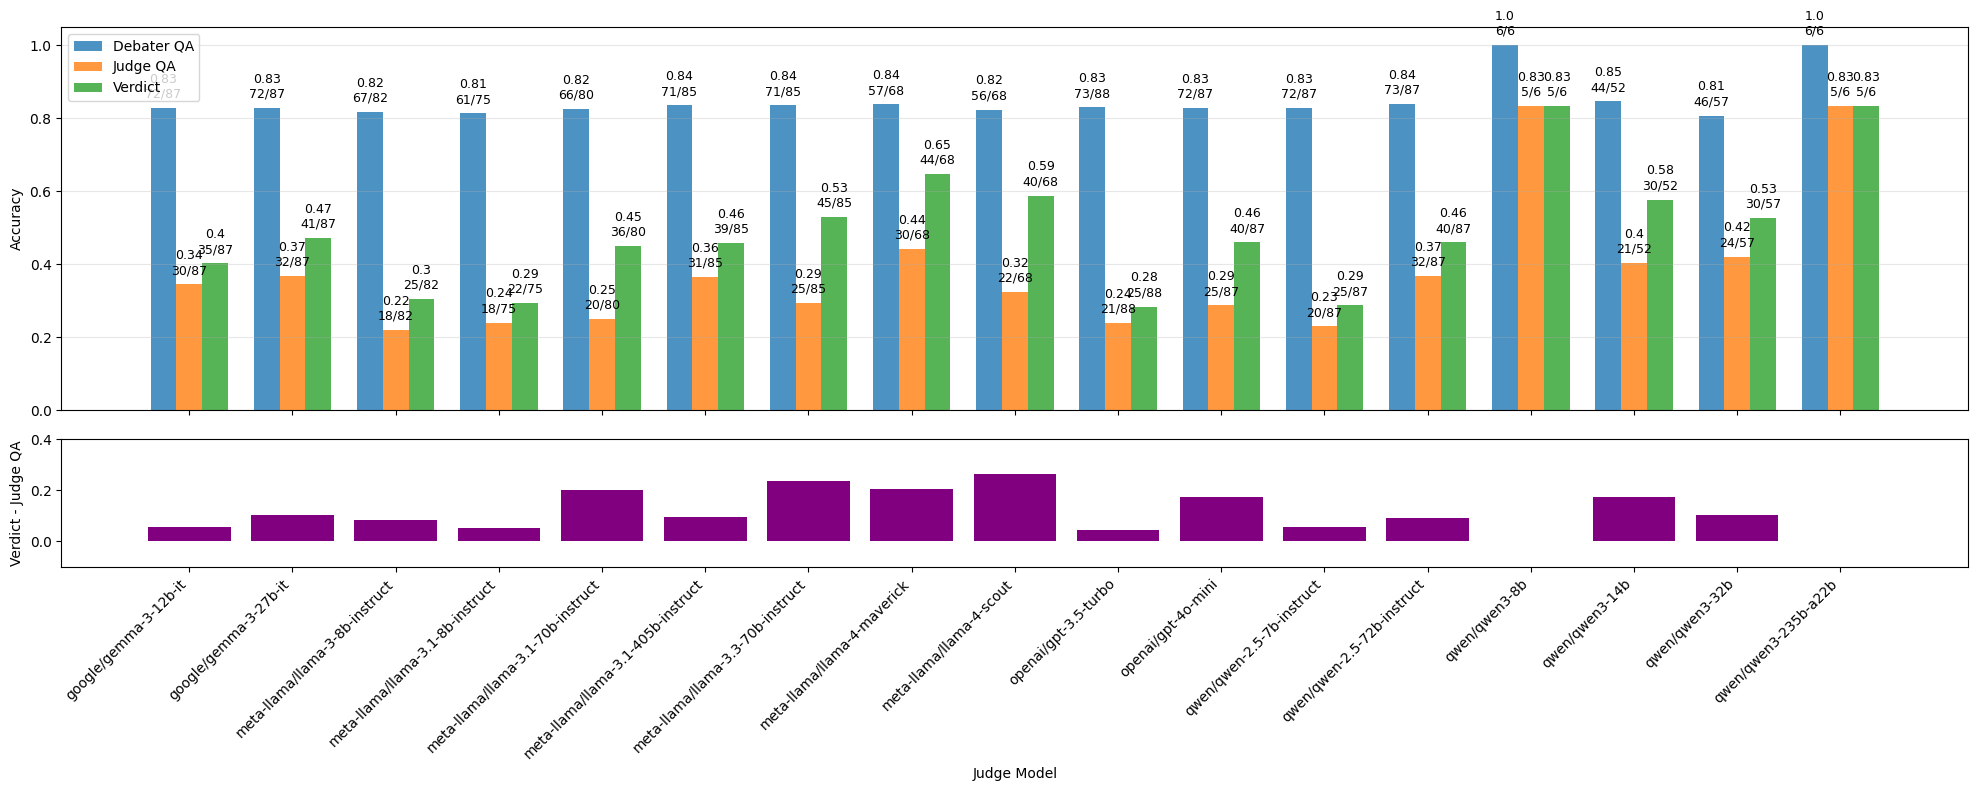

In [357]:
# There's a column called high-level domain in gpqa dataset
# Let's get the data and merged with the results_df

unique_df = unique_df_gpqa_4_choice

dedupe_columns = dedupe_columns_gpqa_4_choice # doesn't matter which one
domain = 'Chemistry'
# domain = 'Physics'
# domain = 'Biology'

dataset = load_dataset('Idavidrein/gpqa', 'gpqa_diamond')['train']
dataset_df = dataset.to_pandas()
dataset_df = dataset_df.rename({'Question': 'question', 'High-level domain': 'high_level_domain'}, axis=1)
unique_df = unique_df.merge(dataset_df[['question', 'high_level_domain']], on='question', how='left')
unique_df = unique_df[unique_df['high_level_domain'] == domain]
results_df = results_by_config(unique_df, dedupe_columns)

plot_results_by_name(results_df)


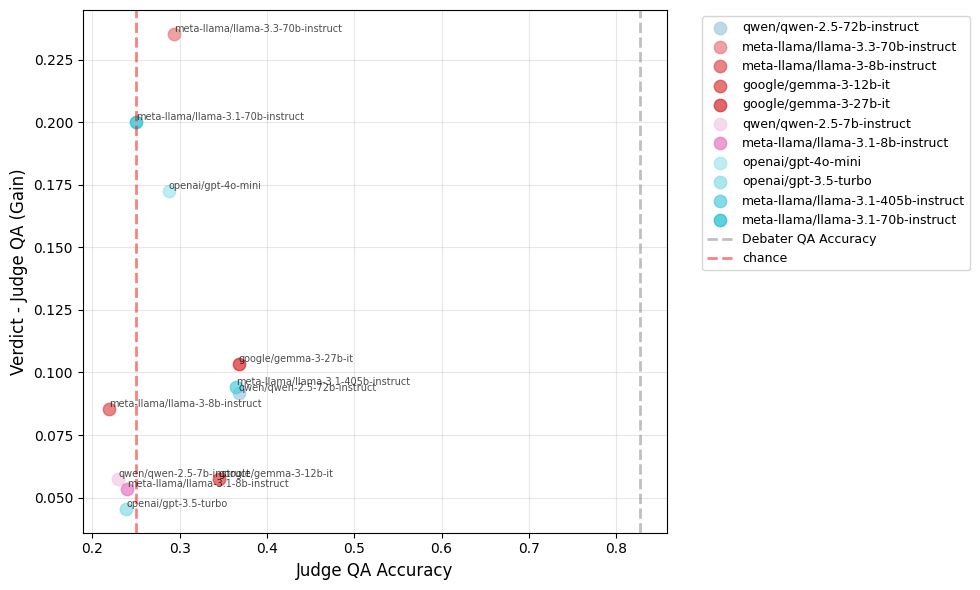

In [359]:
# Add the high-level domain to the records

results_df = results_df[results_df['n_total'] > 70]

plot_gain_scatter(results_df, n_choices=4)

### Breakdown the results by category for MMLU-Pro

In [290]:
# From TIGER-Lab/MMLU-Pro, there's a column called "category"
# Add this column to the merged_df

verdict_run_id = '9amuk8w'

merged_df = load_debate_and_verdict_and_qa(verdict_run_id)
mmlu_dataset = load_dataset('TIGER-Lab/MMLU-Pro')['test']

category_map = {}
for idx in range(len(mmlu_dataset)):
    category_map[idx] = mmlu_dataset[idx].get('category', None)
merged_df['category'] = merged_df['question_idx'].map(category_map)

print(merged_df['category'].value_counts())



loaded verdict: 9amuk8w: starting records: 1434, dropped 16 without judge QA, dropped 18 without debater QA, final records: 1401
category
law                 176
other               133
economics           129
physics             127
math                121
chemistry           114
health              108
psychology          107
philosophy           74
biology              74
engineering          73
business             62
history              56
computer science     47
Name: count, dtype: int64


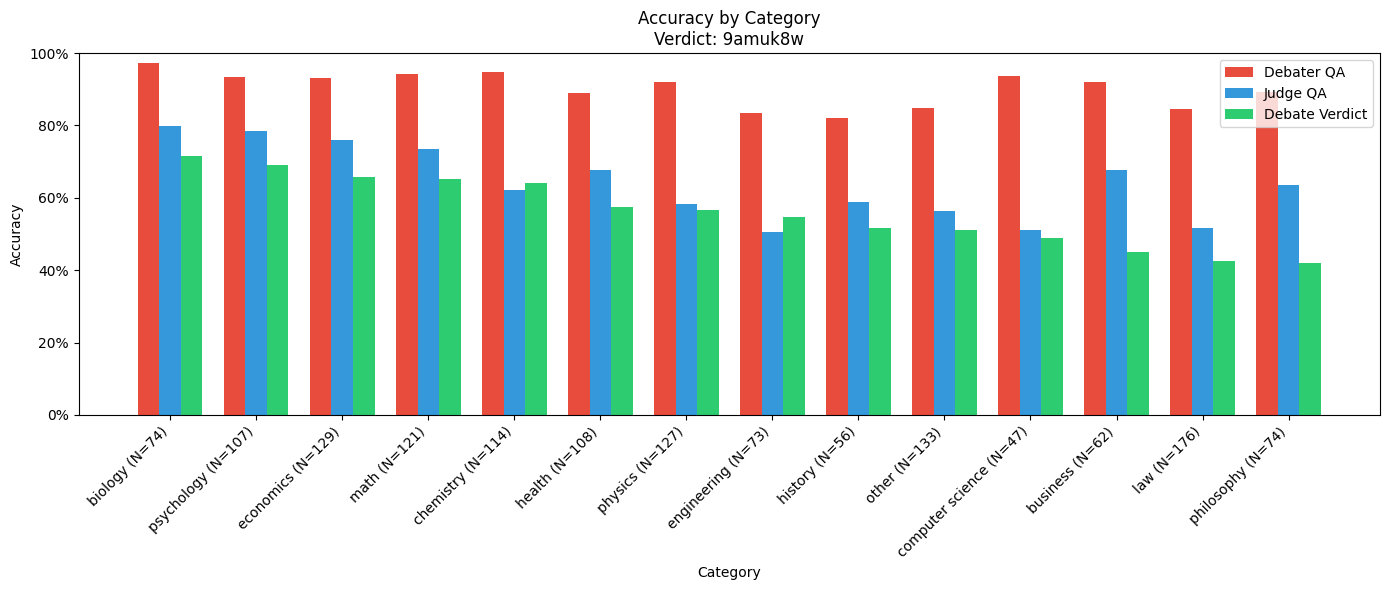


Category Results:
        category is_correct_debater_qa is_correct_judge_qa  is_correct_verdict  count
         biology              0.972973            0.797297            0.716216     74
      psychology              0.934579            0.785047            0.691589    107
       economics              0.930233             0.75969            0.658915    129
            math              0.942149            0.735537            0.652893    121
       chemistry              0.947368            0.622807            0.640351    114
          health              0.888889            0.675926            0.574074    108
         physics               0.92126            0.582677            0.566929    127
     engineering              0.835616            0.506849            0.547945     73
         history              0.821429            0.589286            0.517857     56
           other              0.849624             0.56391            0.511278    133
computer science               0.93

In [291]:
category_results = merged_df.groupby('category').agg({
    'is_correct_debater_qa': 'mean',
    'is_correct_judge_qa': 'mean',
    'is_correct_verdict': ['mean', 'count']
}).reset_index()

category_results.columns = ['category', 'is_correct_debater_qa', 'is_correct_judge_qa', 'is_correct_verdict', 'count']
category_results = category_results.sort_values('is_correct_verdict', ascending=False)

fig, ax = plt.subplots(figsize=(14, 6))

categories = category_results['category']
counts = category_results['count']
x = np.arange(len(categories))
width = 0.25

bars1 = ax.bar(x - width, category_results['is_correct_debater_qa'], width, label='Debater QA', color='#e74c3c')                                                                                                        
bars2 = ax.bar(x, category_results['is_correct_judge_qa'], width, label='Judge QA', color='#3498db')
bars3 = ax.bar(x + width, category_results['is_correct_verdict'], width, label='Debate Verdict', color='#2ecc71')                                                                                                       

ax.set_xlabel('Category')
ax.set_ylabel('Accuracy')
ax.set_title(f'Accuracy by Category\nVerdict: {verdict_run_id}')
ax.set_xticks(x)
category_labels = [f'{cat} (N={cnt})' for cat, cnt in zip(categories, counts)]
ax.set_xticklabels(category_labels, rotation=45, ha='right')
ax.legend()
ax.set_ylim(0, 1)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))

plt.tight_layout()
plt.show()

print(f"\nCategory Results:")
print(category_results.to_string(index=False))

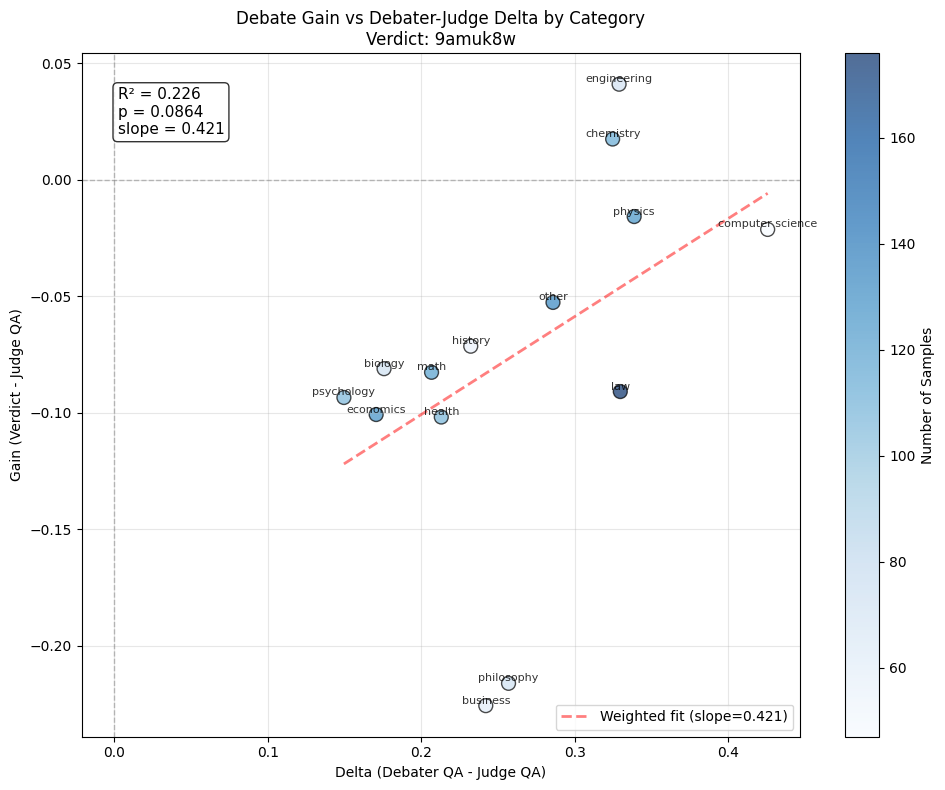


Scatter Plot Data:
        category    delta      gain  count
         biology 0.175676 -0.081081     74
      psychology 0.149533 -0.093458    107
       economics 0.170543 -0.100775    129
            math 0.206612 -0.082645    121
       chemistry 0.324561  0.017544    114
          health 0.212963 -0.101852    108
         physics 0.338583 -0.015748    127
     engineering 0.328767  0.041096     73
         history 0.232143 -0.071429     56
           other 0.285714 -0.052632    133
computer science 0.425532 -0.021277     47
        business 0.241935 -0.225806     62
             law 0.329545 -0.090909    176
      philosophy 0.256757 -0.216216     74


In [11]:
category_results['delta'] = category_results['is_correct_debater_qa'].astype(float) - category_results['is_correct_judge_qa'].astype(float)
category_results['gain'] = category_results['is_correct_verdict'].astype(float) - category_results['is_correct_judge_qa'].astype(float)

from scipy import stats
from sklearn.linear_model import LinearRegression

x = category_results['delta'].values.astype(float)
y = category_results['gain'].values.astype(float)
weights = category_results['count'].values.astype(float)

model = LinearRegression()
model.fit(x.reshape(-1, 1), y, sample_weight=weights)
slope = model.coef_[0]
intercept = model.intercept_

y_pred = model.predict(x.reshape(-1, 1))
ss_res = np.sum(weights * (y - y_pred)**2)
ss_tot = np.sum(weights * (y - np.average(y, weights=weights))**2)
r_squared = 1 - (ss_res / ss_tot)

pearson_r, p_value = stats.pearsonr(x, y)

fig, ax = plt.subplots(figsize=(10, 8))

scatter = ax.scatter(category_results['delta'], category_results['gain'], 
                     c=category_results['count'], s=100, cmap='Blues', alpha=0.7, edgecolors='black')

x_line = np.linspace(x.min(), x.max(), 100)
y_line = slope * x_line + intercept
ax.plot(x_line, y_line, 'r--', linewidth=2, alpha=0.5, label=f'Weighted fit (slope={slope:.3f})')

for i, row in category_results.iterrows():
    ax.annotate(row['category'], (row['delta'], row['gain']), 
                fontsize=8, ha='center', va='bottom', alpha=0.8)

ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax.axvline(x=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)

stats_text = f'R² = {r_squared:.3f}\np = {p_value:.4f}\nslope = {slope:.3f}'
ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax.set_xlabel('Delta (Debater QA - Judge QA)')
ax.set_ylabel('Gain (Verdict - Judge QA)')
ax.set_title(f'Debate Gain vs Debater-Judge Delta by Category\nVerdict: {verdict_run_id}')
ax.grid(True, alpha=0.3)
ax.legend()

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Number of Samples')

plt.tight_layout()
plt.show()

print("\nScatter Plot Data:")
print(category_results[['category', 'delta', 'gain', 'count']].to_string(index=False))


### Analysis across verdict runs

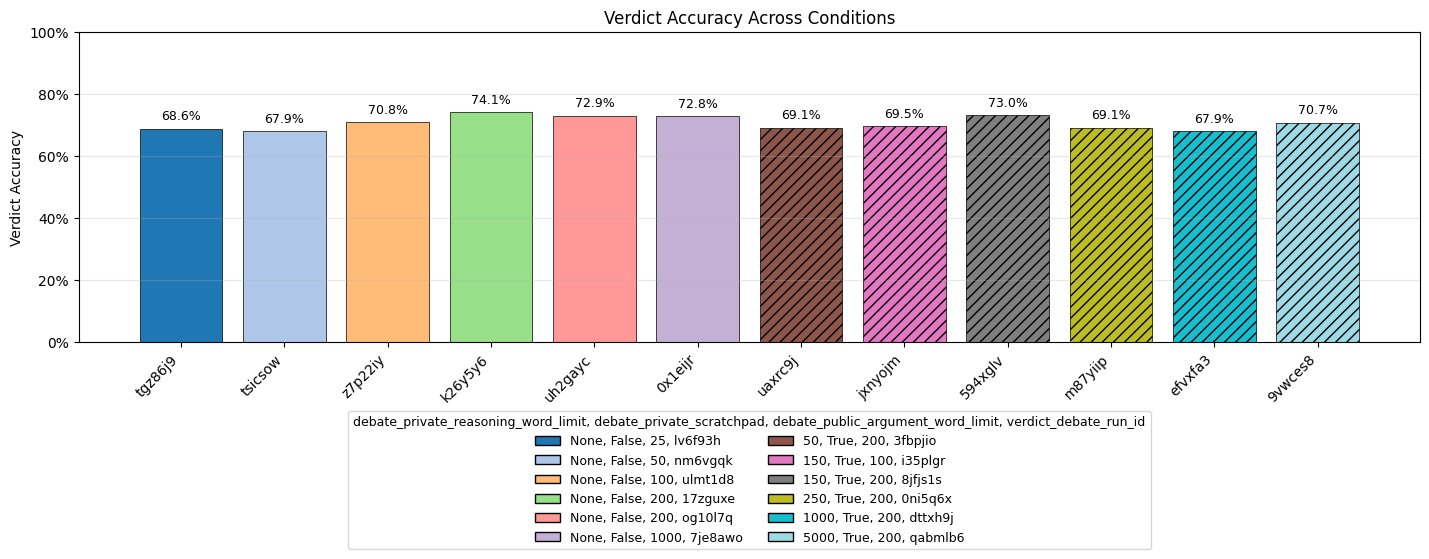

Differing parameters: ['debate_private_reasoning_word_limit', 'debate_private_scratchpad', 'debate_public_argument_word_limit', 'verdict_debate_run_id']

Accuracies:
  tgz86j9: 68.65%
  tsicsow: 67.86%
  z7p22iy: 70.83%
  k26y5y6: 74.09%
  uh2gayc: 72.92%
  0x1eijr: 72.83%
  uaxrc9j: 69.07%
  jxnyojm: 69.54%
  594xglv: 73.02%
  m87yiip: 69.07%
  efvxfa3: 67.88%
  9vwces8: 70.68%


In [20]:
def get_combined_config(verdict_run_id):
    df = load_debate_and_verdict(verdict_run_id)
    return {col.replace('config_', ''): df.iloc[0][col] for col in df.columns if col.startswith('config_')}

verdicts_run_ids = ['uh2gayc', 'z7p22iy', 'jxnyojm', '594xglv', 'm87yiip', '0x1eijr', 'k26y5y6', 'efvxfa3', '9vwces8', 'uaxrc9j', 'tgz86j9', 'tsicsow']

all_configs = {}
for verdict_run_id in verdicts_run_ids:
    config = get_combined_config(verdict_run_id)
    if config:
        all_configs[verdict_run_id] = config

metadata_keys = {'run_id', 'record_id', 'datetime', 'debate_run_id', 'verdict_run_id'}
all_param_keys = set()
for config in all_configs.values():
    all_param_keys.update(k for k in config.keys() if k not in metadata_keys)

differing_params = []
for param_key in sorted(all_param_keys):
    values = [all_configs.get(vid, {}).get(param_key) for vid in verdicts_run_ids if vid in all_configs]
    unique_values = set(v for v in values if v is not None)
    if len(unique_values) > 1:
        differing_params.append(param_key)

accuracies = []
value_lists = []
run_ids_included = []

for verdict_run_id in verdicts_run_ids:
    if verdict_run_id not in all_configs:
        continue
    
    df = load_verdict(verdict_run_id)
    accuracy = df['is_correct_verdict'].mean()
    accuracies.append(accuracy)
    run_ids_included.append(verdict_run_id)
    
    config = all_configs[verdict_run_id]
    values = []
    for param in differing_params:
        value = config.get(param)
        if value is not None:
            values.append(str(value))
        else:
            values.append("None")
    value_lists.append(", ".join(values))

# Sort by parameter values
def smart_sort_key(item):
    _, _, value_str = item
    parts = value_str.split(", ")
    result = []
    for part in parts:
        if part == "None":
            result.append((0, None))
        elif part == "False":
            result.append((1, False))
        elif part == "True":
            result.append((2, True))
        else:
            try:
                result.append((3, int(part)))
            except ValueError:
                result.append((4, part))
    return result

sorted_data = sorted(zip(accuracies, run_ids_included, value_lists), key=smart_sort_key)
accuracies, run_ids_included, value_lists = zip(*sorted_data)

colors = plt.cm.tab20(np.linspace(0, 1, len(accuracies)))

fig, ax = plt.subplots(figsize=(max(10, len(accuracies) * 1.2), 6))

# Create bars with hatching for scratchpad runs
bars = []
for idx in range(len(accuracies)):
    config = all_configs[run_ids_included[idx]]
    has_scratchpad = config.get("debate_private_scratchpad", False)
    hatch = "///" if has_scratchpad else None
    bar = ax.bar(idx, accuracies[idx], color=colors[idx], hatch=hatch, edgecolor="black", linewidth=0.5)
    bars.append(bar)
ax.set_xticks(range(len(accuracies)))
ax.set_xticklabels(run_ids_included, rotation=45, ha='right')
ax.set_ylabel('Verdict Accuracy')
ax.set_ylim(0, 1)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
ax.set_title('Verdict Accuracy Across Conditions')
ax.grid(True, alpha=0.3, axis='y')

for i, acc in enumerate(accuracies):
    ax.text(i, acc + 0.02, f'{acc:.1%}', ha='center', va='bottom', fontsize=9)

param_header = ", ".join(differing_params)
legend_elements = [plt.Rectangle((0,0),1,1, facecolor=colors[i], edgecolor='black', label=value_lists[i]) 
                   for i in range(len(value_lists))]
legend = ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.2), 
                   ncol=2, fontsize=9, title=param_header, title_fontsize=9, frameon=True)
plt.tight_layout()
plt.show()

print(f"Differing parameters: {differing_params}")
print(f"\nAccuracies:")
for vid, acc in zip(run_ids_included, accuracies):
    print(f"  {vid}: {acc:.2%}")


### Analyze token usage in the debate run

In [12]:
run_id = 'dttxh9j'

debate_df = load_debate(run_id)

record_ids = []
completion_tokens_used_per_debate = []
reasoning_tokens_used_per_debate = []
for i, row in debate_df.iterrows():
    if row['success'] == False:
        continue
    record_ids.append(row['record_id'])
    debate_history = row['debate_history']
    completion_tokens_used_this_debate, reasoning_tokens_used_this_debate = 0, 0
    for turn in debate_history:
        completion_tokens_used_this_debate += turn['token_usage']['completion_tokens']
        if 'completion_tokens_details' in turn['token_usage'] and turn['token_usage']['completion_tokens_details'] is not None:
            reasoning_tokens_used_this_debate += turn['token_usage']['completion_tokens_details']['reasoning_tokens']
        else:
            reasoning_tokens_used_this_debate += 0
    completion_tokens_used_per_debate.append(completion_tokens_used_this_debate)
    reasoning_tokens_used_per_debate.append(reasoning_tokens_used_this_debate)

print(record_ids)
print(f"completion_tokens_used_per_debate: {completion_tokens_used_per_debate}")
print(f"reasoning_tokens_used_per_debate: {reasoning_tokens_used_per_debate}")


['kzrous5', 'hk8ubqd', '1qcavop', 'b4wassv', 'x3lzxbz', 'jh5jbyi', 'l1s826e', 'vxw819y', 'ft9z8yh', 'qstcwfj', 'j62qcbg', 'phcxgez', 'va1sr4j', '5d9hjkx', 'p4yqd71', 'r63u681', '655fxkg', 'stu7xez', '2dfhjyj', 'kyrmnkc', 'c7sckgd', 'iudop67', 'ecgh0pm', '8j7dz44', 'b1rimbx', 'cr0cdmf', 'a9bsn0e', 'c106unw', '3o3oiz2', 'x6gy4lo', 'pd11e05', 'cjzpl8j', '9pix5ix', '65943js', 'qn8ii0f', 'nqfni3t', 'zbcgy6y', 'y5658ma', 'xdybjn8', '6qwbjic', '7ap29ri', 'netnuxw', 'k8oab27', 'tkq4jwm', 'cb69ar8', 'xijlfq4', 'ynxmamb', 'f5dz059', 'mxtsuep', '3rl3ehv', '0i9k3x0', 'img9dz9', 'n159vel', 'ol30dgs', 'vt4ufjj', 'vy0uxu4', 'axegwzl', 'lp5odyr', 'rcucqoa', '2dmo93w', 'ran59bn', 'v4eww3t', 'cuhgta4', 'usa1ce0', 'w9a4xcq', 'srmo6fm', 's6b9i6d', 'c2j4go8', 'z34r23h', 'qifw16n', 'hm1rbnf', '0156a9s', 'k3414go', 'oofglb7', '9z1omif', 'ure0jqh', 'ot76ght', 'iilcjvg', '65effsm', 'qr8rx44', '59ctvmi', 'axqjuyg', '3qp6fws', 'bfqhed6', 'ywfgkuk', 'xxthyfy', 'fumf7yx', '4stbyiy', '5gc75gp', '32tfp35', '6otyiog'